# Dashboard zur Auswertung von Rezepten

Grundlage sind die Datenbank Spoonacular sowie der Subreddit "food", welcher beginnend vom 01.02.2021 bis zum 15.04.2021 im 10 Minutentakt auf die Kategorie "Top" abgefragt wurde

# Statische Variablen und Imports

In [1]:
# Final Variablen
API_KEY_SPOONACULAR = "146fe79a630b4afb8306a2985bedc64c"
API_KEY_SPOONACULAR = "6e0a91c81983423792b327bc4b78bb1d"

API_KEY_REDDIT = "KAJ2xGzCOlH3hyTRADNdSBDuTBORvw"
API_CLIENTID_REDDIT = "tSemvcUBRFCTYQ"

USERNAME_REDDIT = "Short-Arrival7632"
PW_REDDIT = "cookies123"

In [2]:
# KONFIGURATION

LIMIT_REDDIT_POSTS = 100
LIMIT_SPOONACULAR_RECIPES = 100
REDDIT_SAVE_INTERVALL = 10 # Minuten

In [3]:
# Auf Windows ausführen (einmalig)
# !pip install praw
# !pip install pandas
# !pip install matplotlib
# !pip install mysql-connector-python

In [4]:
# Auf Linux ausführen (einmalig)
"""
!pip3 install praw
!pip3 install pandas
!pip3 install matplotlib
!pip3 install mysql-connector-python
"""

'\n!pip3 install praw\n!pip3 install pandas\n!pip3 install matplotlib\n!pip3 install mysql-connector-python\n'

In [5]:
import praw
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as pdt
import mysql.connector
import re
from tqdm import tqdm

# Daten laden

In [6]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )


In [7]:
cursor = db_connection.cursor()

In [8]:
dfr = pd.read_sql("SELECT * FROM reddit order by ups desc", db_connection)

# Daten vorbereiten 
(Duplikate entfernen, Zeit normalisieren, Dauer Post berechnen)

In [9]:
# Zeit normalisieren
dfr["day_created"] = pd.to_datetime(dfr["day_created"]).dt.date
dfr["time_created"] = pd.to_datetime(dfr["time_created"]).dt.time
dfr["curr_time"] = pd.to_datetime(dfr["curr_time"])

dtstuff = dfr.apply(
    lambda row: datetime.combine(row['day_created'], row['time_created']),
    axis=1
)
dfr["time"] = dtstuff
dfr["time"] = dfr["time"] - timedelta(hours=10)

In [10]:
# Dauer hinzufügen
dfr["duration"] = dfr["curr_time"] - dfr["time"]
dfr["duration_seconds"] = dfr["duration"].dt.total_seconds()
dfr["duration_seconds"]
dfr["duration_hours"] = dfr["duration_seconds"]/3600

In [11]:
# Duplikate entfernen
dfr["post_id"] = dfr.agg('{0[author]}-{0[time]}'.format, axis=1) # dauert lange, ist aber wichtig
test = dfr.groupby("post_id")["ups"].agg('max').reset_index().rename({"ups":"max_ups"})
df = pd.merge(dfr, test, on="post_id")
dfr_wod = df.drop_duplicates(subset=["post_id"]).copy()

In [12]:
# Max Ups hinzufügen
dfr = pd.merge(dfr, dfr.groupby("post_id")["ups"].agg("max").reset_index(), on="post_id")

# Max Comments hinzufügen
dfr = pd.merge(dfr, dfr.groupby("post_id")["num_comments"].agg("max").reset_index(), on="post_id")

dfr.rename({"ups_y":"max_ups", "num_comments_y":"max_comments", "ups_x":"ups", "num_comments_x":"num_comments"}, axis=1, inplace=True)

In [24]:
# Daten vorbereiten

# reddit Daten, ohne Duplikate, gekürztes Dataframe (Spaltentechnisch)
dfr_wods = dfr.drop_duplicates(subset=["post_id"]).copy()

# reddit Daten, ohne Duplikate, größer 0.9 Quantil der max. Upvotes des Posts
dfr_wodss = dfr_wods[(dfr_wods["max_ups"]>dfr_wods["ups"].quantile(0.9))].copy()
dfr_wodsl = dfr_wods[dfr_wods["max_ups"]<dfr_wods["ups"].quantile(0.1)].copy()

# reddit Daten, nach Duration sortiert, ohne Duplikate
dfr_ds = dfr.sort_values(by=["duration"], ascending=False)
dfr_ds.drop_duplicates(subset=["post_id"], inplace=True)

# Analyse der Postzeit
### 1. Postzeit Beste (>0.9 Quantil) vs Schlechteste (<0.1 Quantil) Posts

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


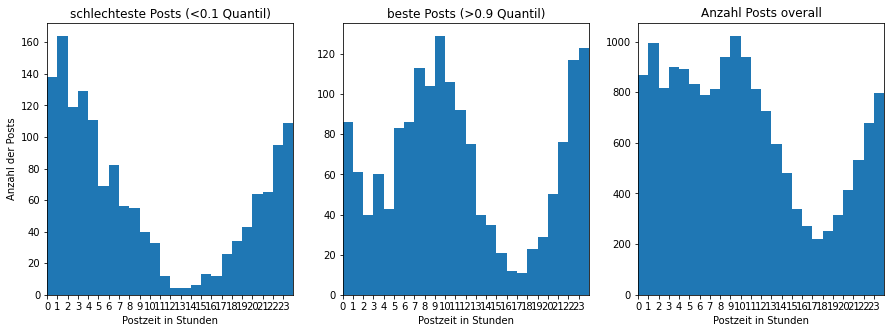

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=False, figsize=(15,5))

ax1.set_title("schlechteste Posts (<0.1 Quantil)")
ax1.hist(pd.to_numeric(dfr_wodsl["hour_created"]), bins=range(25))
ax1.set_xlabel("Postzeit in Stunden")
ax1.set_xticks(range(24))
ax1.set_xlim([0,24])
ax1.set_ylabel("Anzahl der Posts")

ax2.set_title("beste Posts (>0.9 Quantil)")
ax2.hist(pd.to_numeric(dfr_wodss["hour_created"]), bins=range(25))
ax2.set_xlabel("Postzeit in Stunden")
ax2.set_xticks(range(24))
ax2.set_xlim([0,24])

ax3.set_title("Anzahl Posts overall")
ax3.hist(pd.to_numeric(dfr_wods["hour_created"]), bins=range(25))
ax3.set_xlabel("Postzeit in Stunden")
ax3.set_xticks(range(24))
ax3.set_xlim([0,24])

fig.show()

### 2. Dauer in Top in Abhängigkeit der Postzeit

In [16]:
v=[]
for i in range(1,25):
    v.append((dfr_ds[dfr_ds["time"].dt.hour==i]["duration"].mean().total_seconds())/3600)

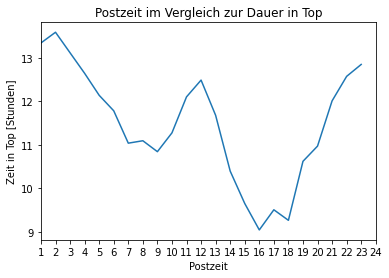

In [17]:
plt.plot([x for x in range(1,25)], v)

# plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit im Vergleich zur Dauer in Top")
plt.xticks([x for x in range(1,25)])
plt.xlim([1,24])
plt.xlabel("Postzeit")
plt.ylabel("Zeit in Top [Stunden]")
plt.show()

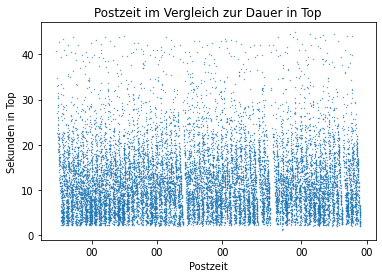

In [18]:
myFmt = pdt.DateFormatter("%H")

plt.scatter(dfr_ds["time"], (dfr_ds["duration_seconds"]/3600), s=0.1)

plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit im Vergleich zur Dauer in Top")
plt.xlabel("Postzeit")
plt.ylabel("Sekunden in Top")
plt.show()

# Dauer in Top
### 1. längste Zeit in Top

In [19]:
dfr_ds[["author", "ups", "duration_hours"]].head()

,author,ups,duration_hours
6155,sugardevotion,23412,44.929772
3312,everythingbagellover,27670,44.621961
23124,thebreadittor,12059,44.500289
18128,Zeromorph,15133,44.451430
21065,rcc52779,13062,44.408815


### 2. Durchschnittliche Zeit in Top

In [20]:
v = []
v.append(["all",(dfr_ds["duration"].mean().total_seconds())/3600])
v.append([">0.9 Quantil",(dfr_ds[dfr_ds["ups"]>dfr_ds["ups"].quantile(0.9)]["duration"].mean().total_seconds())/3600])
v.append(["<0.9 Quantil",(dfr_ds[dfr_ds["ups"]<dfr_ds["ups"].quantile(0.9)]["duration"].mean().total_seconds())/3600])
v.append(["<0.1 Quantil",(dfr_ds[dfr_ds["ups"]<dfr_ds["ups"].quantile(0.1)]["duration"].mean().total_seconds())/3600])
for val in v:
    print(val)

['all', 11.481608344444444]
['>0.9 Quantil', 26.416230633055555]
['<0.9 Quantil', 9.824064594444444]
['<0.1 Quantil', 3.7501931119444443]


/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


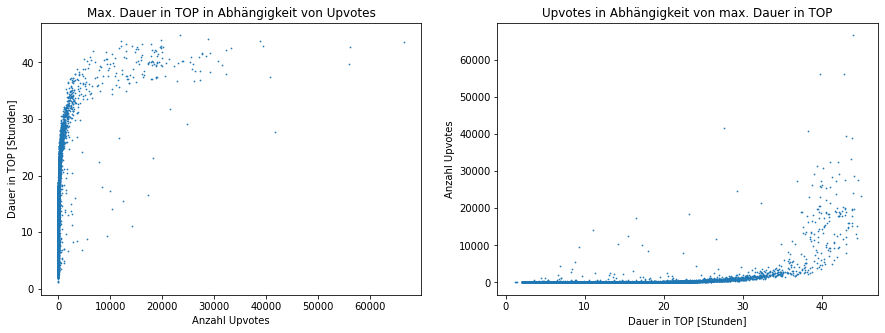

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.scatter(dfr_wods["max_ups"], dfr_wods["duration_hours"],  s=0.5)
ax1.set_title("Max. Dauer in TOP in Abhängigkeit von Upvotes")
ax1.set_xlabel("Anzahl Upvotes")
ax1.set_ylabel("Dauer in TOP [Stunden]")

ax2.scatter((dfr_ds["duration_seconds"]/3600),dfr_ds["ups"],  s=0.5)
ax2.set_title("Upvotes in Abhängigkeit von max. Dauer in TOP")
ax2.set_ylabel("Anzahl Upvotes")
ax2.set_xlabel("Dauer in TOP [Stunden]")

fig.show()

### 3. Zusammenhang (Korrelation) zwischen Erstellungszeitpunkt, Dauer und Upvotes

In [31]:
dfr_wods[["max_ups", "duration_seconds", "time"]].corr()

,max_ups,duration_seconds
max_ups,1.000000,0.436441
duration_seconds,0.436441,1.000000


- Es könnte ein mittelstarker Zusammenhang zwischen der Dauer in Sekunden und den Upvotes bestehen.
- Es könnte ein schwacher Zusammenhang zwischen dem Erstellungszeitpunkt und den Upvotes bestehen.
- Es könnte ein schwacher Zusammenhang zwischen der Dauer in Sekunden und dem Erstellungszeitpunkt bestehen.

# Verlauf der Upvotes über die Zeit
### 1. Daten filtern

In [32]:
dfru = pd.read_sql("SELECT * FROM users", db_connection)
dfru.set_index("username", inplace=True)

In [33]:
new_df = dfr.join(dfru, on="author")

In [36]:
# x = new_df[["title", "duration_hours", "ups", "post_id"]].groupby('post_id')
x = dfr[["title", "duration_hours", "ups", "post_id", "max_ups"]].groupby('post_id')
y_high = x.filter(lambda x: x["max_ups"].max() > dfr_wods["max_ups"].quantile(0.9))
y_low = x.filter(lambda x: x["max_ups"].max() < dfr_wods["max_ups"].quantile(0.1))
y_med = x.filter(lambda x: x["max_ups"].max() < dfr_wods["max_ups"].quantile(0.9))
z = y_high.groupby("post_id")

### 2. Zeitlicher Verlauf für Posts  > 0.9 Quantil Upvotes maximal (erste 10 Ergebnisse)

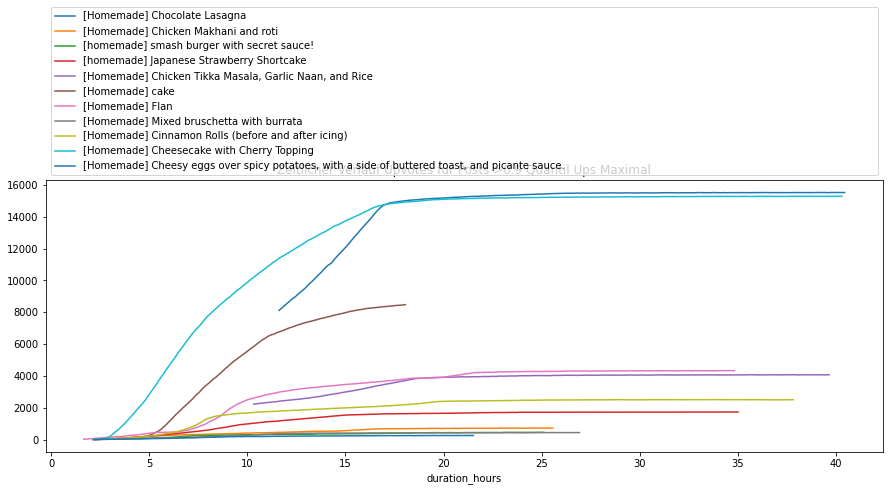

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
zähler = 0
for i, k in enumerate(z):
    label, df = k
    df.sort_values(by="duration_hours", inplace=True)
    df.plot(x="duration_hours", y="ups", kind="line", ax=ax, label=df["title"].iloc[0])
    if zähler == 10:
        break
    else:
        zähler +=1
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand")
plt.title("Zeitlicher Verlauf Upvotes für Posts >0.9 Quantil Ups Maximal")
plt.show()


### 3. Verlauf der Upvotes im Durchschnitt
Durchschnitt berechnen für 4 Bereiche (>0.9 Quantil, <0.9 Quantil, <0.1 Quantil, ohne Einschränkung) 

In [38]:
hour_mean = []
h_mean_y_low = []
h_mean_y_med = []
h_mean_y_high = []
h_mean_all = []
h = []

for i in range(1,40):
    hour_mean.append([i, dfr[(dfr["duration_hours"]>i) & (dfr["duration_hours"]<i+1)]["ups"].mean()])
    h_mean_y_high.append(y_high[(y_high["duration_hours"]>i) & (y_high["duration_hours"]<i+1)]["ups"].mean())
    h_mean_y_med.append(y_med[(y_med["duration_hours"]>i) & (y_med["duration_hours"]<i+1)]["ups"].mean())
    h_mean_y_low.append(y_low[(y_low["duration_hours"]>i) & (y_low["duration_hours"]<i+1)]["ups"].mean())
    
    h_mean_all.append(dfr[(dfr["duration_hours"]>i) & (dfr["duration_hours"]<i+1)]["ups"].mean())
    h.append(i)

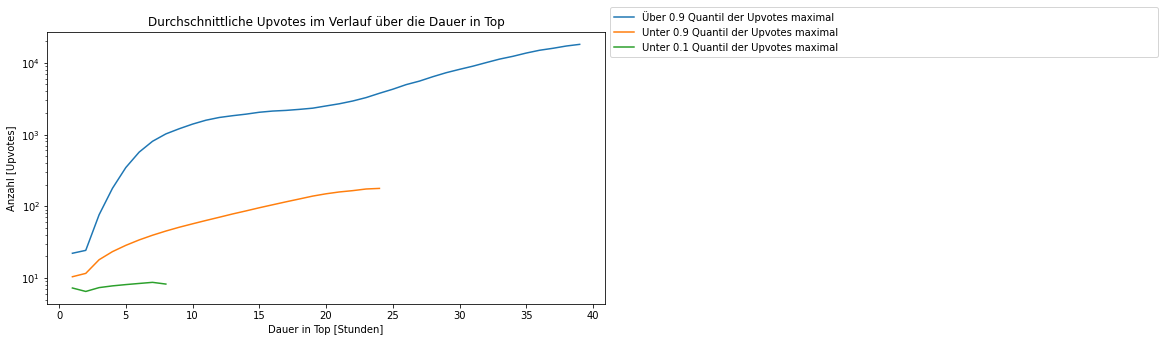

In [39]:
plt.figure(figsize=(10,5))
plt.title("Durchschnittliche Upvotes im Verlauf über die Dauer in Top")
plt.xlabel("Dauer in Top [Stunden]")
plt.ylabel("Anzahl [Upvotes]")
plt.yscale("log")

plt.plot(h, h_mean_y_high, label="Über 0.9 Quantil der Upvotes maximal")
plt.plot(h, h_mean_y_med, label="Unter 0.9 Quantil der Upvotes maximal")
plt.plot(h, h_mean_y_low, label="Unter 0.1 Quantil der Upvotes maximal")

# plt.plot(h, h_mean_all, label="Alle Posts")
plt.legend(bbox_to_anchor=(1, 1, 1, 0), loc="right", mode="expand")
plt.show()

# Analyse der Länge des Titels
### 1. Länge des Titels in Bezug auf Upvotes

In [42]:
dfr_wods["title_length"] = dfr_wods["title"].apply(len)
dfr_ds["title_length"] = dfr_ds["title"].apply(len)

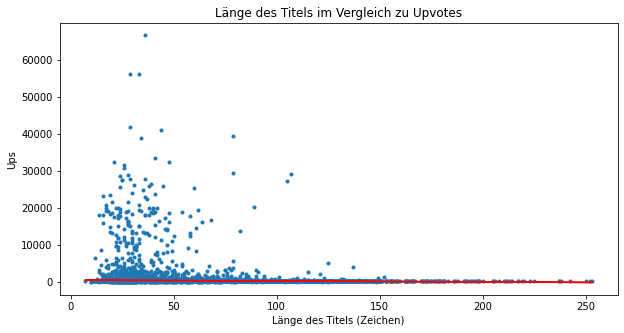

In [69]:
coef1 = np.polyfit(dfr_ds["title_length"],dfr_ds["ups"],1)
poly1d_fn1 = np.poly1d(coef1) 

plt.figure(figsize=(10,5))
#plt.plot(dfr_wods["title_length"], dfr_wods["ups"], "o", markersize=1)
plt.plot(dfr_wods["title_length"], dfr_wods["ups"], "o", dfr_ds["title_length"], poly1d_fn1(dfr_ds["title_length"]), '-r',markersize=3)
plt.title("Länge des Titels im Vergleich zu Upvotes")
plt.xlabel("Länge des Titels (Zeichen)")
plt.ylabel("Ups")
#plt.yscale("log")
plt.show()

### 2. Länge des Titels in Bezug auf Dauer in Top

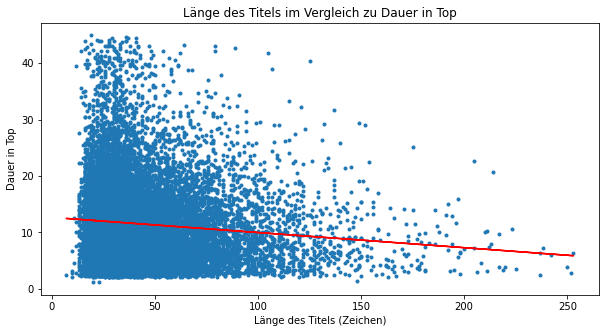

In [68]:
coef1 = np.polyfit(dfr_ds["title_length"],dfr_ds["duration_hours"],1)
poly1d_fn1 = np.poly1d(coef1) 

plt.figure(figsize=(10,5))
plt.plot(dfr_ds["title_length"], dfr_ds["duration_hours"], 'o', dfr_ds["title_length"], poly1d_fn1(dfr_ds["title_length"]), '-r',markersize=3)
plt.title("Länge des Titels im Vergleich zu Dauer in Top")
plt.xlabel("Länge des Titels (Zeichen)")
plt.ylabel("Dauer in Top")
plt.show()

In [47]:
dfr_ds[["title_length", "ups", "duration_seconds"]].corr()

,title_length,ups,duration_seconds
title_length,1.000000,-0.033622,-0.098141
ups,-0.033622,1.000000,0.430152
duration_seconds,-0.098141,0.430152,1.000000


# Analyse der Anzahl der Kommentare
### 1. Anzahl Kommentare in Abhängigkeit von Ups

In [48]:
m = int(dfr_ds["ups"].max())
x = []
y = []
for i in range(0,m, 1000):
    x.append(i)
    y.append(dfr_ds[(dfr_ds["ups"]<=i)&(dfr_ds["ups"]>i-1000)]["num_comments"].mean())

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


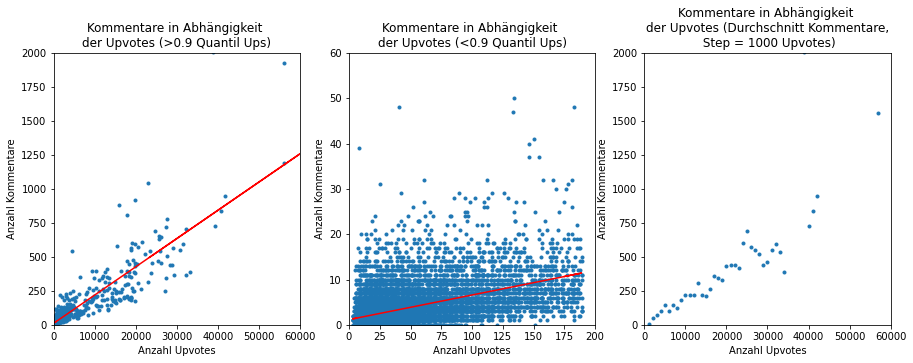

In [49]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
dfr_ups_comments_top = dfr_ds[dfr_ds["ups"]>dfr_ds["ups"].quantile(0.9)]
dfr_ups_comments_med = dfr_ds[dfr_ds["ups"]<dfr_ds["ups"].quantile(0.9)]

# Regressionsgrade

coef1 = np.polyfit(dfr_ups_comments_top["ups"],dfr_ups_comments_top["num_comments"],1)
poly1d_fn1 = np.poly1d(coef1) 

coef2 = np.polyfit(dfr_ups_comments_med["ups"],dfr_ups_comments_med["num_comments"],1)
poly1d_fn2 = np.poly1d(coef2) 


# Achsen
ax1.plot(dfr_ups_comments_top["ups"], dfr_ups_comments_top["num_comments"], 'o', dfr_ups_comments_top["ups"], poly1d_fn1(dfr_ups_comments_top["ups"]), '-r',markersize=3)
ax1.set_xlim([0,60000])
ax1.set_ylim([0,2000])
ax1.set_xlabel("Anzahl Upvotes")
ax1.set_ylabel("Anzahl Kommentare")
ax1.set_title("Kommentare in Abhängigkeit \nder Upvotes (>0.9 Quantil Ups)")

ax2.plot(dfr_ups_comments_med["ups"],dfr_ups_comments_med["num_comments"], 'o', dfr_ups_comments_med["ups"], poly1d_fn2(dfr_ups_comments_med["ups"]), '-r',markersize=3)
ax2.set_xlim([0,200])
ax2.set_ylim([0,60])
ax2.set_xlabel("Anzahl Upvotes")
ax2.set_ylabel("Anzahl Kommentare")
ax2.set_title("Kommentare in Abhängigkeit \nder Upvotes (<0.9 Quantil Ups)")

ax3.plot(x,y,'o',markersize=3)
ax3.set_xlim([0,60000])
ax3.set_ylim([0,2000])
ax3.set_xlabel("Anzahl Upvotes")
ax3.set_ylabel("Anzahl Kommentare")
ax3.set_title("Kommentare in Abhängigkeit \nder Upvotes (Durchschnitt Kommentare,\n Step = 1000 Upvotes)")

fig.show()

In [62]:
dfr_ds[["ups", "num_comments"]].corr()

,ups,num_comments
ups,1.000000,0.907093
num_comments,0.907093,1.000000


Es besteht ein starker Zusammenhang zwischen den maximalen Upvotes und der Anzahl an Kommentaren

### 2. Anzahl Kommentare in Abhängigkeit von Postzeit

In [110]:
graph_df = dfr_wods[["time", "max_comments"]].copy()
dtstuff = graph_df.apply(
    lambda row: datetime.combine(datetime.today(), row['time'].time()),
    axis=1
)
graph_df["normalized_time"] = dtstuff
graph_df.sort_values(by="normalized_time", inplace=True)

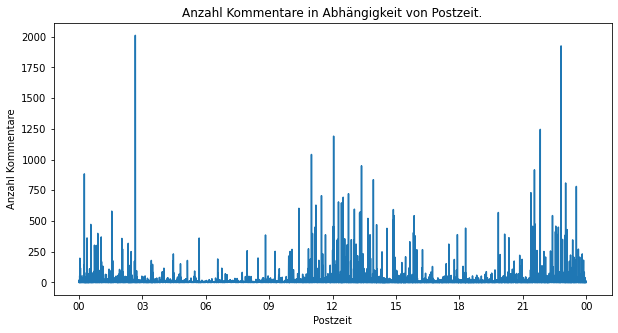

In [118]:
myFmt = pdt.DateFormatter("%H")
plt.figure(figsize=(10,5))
plt.plot(graph_df["normalized_time"],
           graph_df["max_comments"])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Anzahl Kommentare in Abhängigkeit von Postzeit.")
plt.xlabel("Postzeit")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 3. Anzahl Kommentare in Abhängigkeit vom Autor

In [119]:
df_counts = pd.DataFrame(dfr_ds[["author", "num_comments", "title"]].value_counts(subset=["author"]), columns=["num_posts"])
df_counts.reset_index(inplace=True)

In [120]:
dfar = pd.merge(dfr_ds, df_counts, on="author")
dfar_f = dfar[(dfar["num_posts"]>2)]
dfar_fg = dfar_f[["author", "title", "ups", "num_posts"]].groupby("author")

In [121]:
df_mean_user = dfar_f[["author", "title", "ups"]].groupby("author").mean()
df_std_user = dfar_f[["author", "title", "ups"]].groupby("author").std()

df_mean_user.rename({"ups":"mean_ups"}, axis=1, inplace=True)
df_std_user.rename({"ups":"std_ups"}, axis=1, inplace=True)

dfar = pd.merge(dfr_ds, df_mean_user, on="author")
dfar = pd.merge(dfar, df_std_user, on="author")

test = dfar_fg.filter(lambda x: (x["ups"].mean() > dfar.drop_duplicates(subset=["author"])["mean_ups"].quantile(0.9)))
dfar_fg = test.groupby("author")
test = dfar_fg.filter(lambda x: (x["ups"].std() < dfar.drop_duplicates(subset=["author"])["std_ups"].quantile(0.9)))

In [122]:
test

,author,title,ups,num_posts
1335,ShirtGeek,[Homemade] Cheeseburger,1657,6
1336,ShirtGeek,[Homemade] Cheeseburger,168,6
1337,ShirtGeek,[Homemade] Cheeseburger,1034,6
1338,ShirtGeek,[Homemade] Eggs Benedict,32,6
1339,ShirtGeek,[Homemade] Quesabirria Burger,23,6
1340,ShirtGeek,[Homemade] Cauliflower Steaks with saffron aioli,16,6
1394,Thechefanderson,[pro/chef] Coconut Tres Leches,1737,5
1395,Thechefanderson,[homemade] Whipped potato purée / Braised beef...,797,5
1396,Thechefanderson,[homemade] Surf & Turf,21,5
1397,Thechefanderson,[homemade]Herb crusted Lamb chop w/ Pesto pasta,16,5


# Lessons Learned

- Dokumentation richtig lesen!
- created time muss nicht gleich created time in utc sein (das kann Auswertungen sehr spaßig machen)
- Reposts sind doof für Analysen (wenn man nicht dran denkt)